In [1]:
from scipy.io import loadmat
import numpy as np

In [2]:
def calc_fairness_metric(constraint, confu_mat, num_groups=2, num_classes=2):
    if constraint == 'eopp':
        '''
        Compute EO disparity
        '''
        group0_tn, group0_fp, group0_fn, group0_tp = confu_mat['0'].ravel()
        group1_tn, group1_fp, group1_fn, group1_tp = confu_mat['1'].ravel()

        pivot = (group0_tp + group1_tp) / (group0_fn + group0_tp + group1_fn + group1_tp)
        group0_tpr = group0_tp / (group0_fn + group0_tp)
        group1_tpr = group1_tp / (group1_fn + group1_tp)

        return max(abs(group0_tpr - pivot), abs(group1_tpr - pivot)) # from fairbatch paper
        #return abs(group0_tp / (group0_fn + group0_tp) - group1_tp / (group1_fn + group1_tp))

    elif constraint == 'eo':
        '''
        Compute ED disparity 
        '''

        group0_tn, group0_fp, group0_fn, group0_tp = confu_mat['0'].ravel()
        group1_tn, group1_fp, group1_fn, group1_tp = confu_mat['1'].ravel()
        
        pivot_1 = (group0_tp + group1_tp) / (group0_fn + group0_tp + group1_fn + group1_tp)
        group0_tpr = group0_tp / (group0_fn + group0_tp)
        group1_tpr = group1_tp / (group1_fn + group1_tp)

        EO_Y_1 = max(abs(group0_tpr - pivot_1), abs(group1_tpr - pivot_1))

        pivot_0 = (group0_fp + group1_fp) / (group0_tn + group0_fp + group1_tn + group1_fp)
        group0_fpr = (group0_fp) / (group0_tn + group0_fp)
        group1_fpr = (group1_fp) / (group1_tn + group1_fp)

        EO_Y_0 = max(abs(group0_fpr - pivot_0), abs(group1_fpr - pivot_0))

        return max(EO_Y_0, EO_Y_1)

    elif constraint == 'dp':
        pass

def calc_acc(constraint, confu_mat, num_classes=2, num_groups=2):
    group0_tn, group0_fp, group0_fn, group0_tp = confu_mat['0'].ravel()
    group1_tn, group1_fp, group1_fn, group1_tp = confu_mat['1'].ravel()
    
    return (group0_tn + group0_tp + group1_tn + group1_tp) / (confu_mat['0'].ravel().sum() + confu_mat['1'].ravel().sum())


In [15]:

method = "reweighting"
dataset = "compas"
sen_attr_dict = {
    "adult": "sex",
    "compas": "sex",
    "retiring_adult": "race",
    "retiring_adult_coverage": "race"
}

sen_attr = sen_attr_dict[dataset]
constraint = "eopp"


In [16]:

filename_epi = "mlp_{}_seed{}_epochs5_bs128_lr{}_decay{:.4f}"
seed_arr = [0, 1, 2, 3, 4]
# seed_arr = [0]
date = "20220214"

if method == "reweighting":
    filename = filename_epi + "_constraint{}_eta{}_iter{}_test_confu"
#     lr_arr = [0.0003, 0.0005]
    lr_arr = [0.0001, 0.0003, 0.0005]
    eta_arr = [0.1, 0.2, 0.3, 0.5, 1.0, 2.0, 3.0, 5.0, 10.0, 20.0, 30.0]
    decay = 0.0005
    iteration = 10
    
elif method == "adv_debiasing":
    filename = filename_epi + "_adv_lamb{}_eta{}_constraint{}_test_confu"
    lr = 0.0005
    decay = 0.0005
#     lamb_arr = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    lamb_arr = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 10.0, 20.0, 30.0, 50.0, 100.0]
#     eta_arr = [0.001, 0.003, 0.005, 0.007, 0.01]
    eta_arr = [0.001, 0.003, 0.005, 0.01]
    


In [17]:

results_fair = np.zeros((len(seed_arr), len(lr_arr), len(eta_arr)))
results_acc = np.zeros((len(seed_arr), len(lr_arr), len(eta_arr)))

for seed in seed_arr:
    for i, lr in enumerate(lr_arr):
        for j, eta in enumerate(eta_arr):
            confu_mat = loadmat("./results/{}/{}/{}/{}".format(date, dataset, method, filename.format(sen_attr, seed, lr, decay, constraint, eta, iteration)), appendmat=False)
#             print(calc_fairness_metric(constraint, confu_mat))
            results_fair[seed, i, j] += calc_fairness_metric(constraint, confu_mat)
            results_acc[seed, i, j] += calc_acc(constraint, confu_mat)

results_fair = np.mean(results_fair, axis=0)
results_acc = np.mean(results_acc, axis=0)


print(results_fair)
print(results_acc)


[[0.19624784 0.1370869  0.10045583 0.03149031 0.02883552 0.01561643
  0.05570422 0.05678048 0.02437851 0.05024269 0.07040476]
 [0.16221247 0.11024353 0.05857004 0.03117376 0.06155405 0.04803106
  0.06780484 0.05494028 0.02738784 0.12421812 0.14551133]
 [0.17433841 0.09090027 0.05550585 0.0490398  0.05441692 0.06160891
  0.06982231 0.04925505 0.12873423 0.13708268 0.23875828]]
[[0.66677472 0.66661264 0.66612642 0.66418152 0.66272285 0.66288493
  0.66726094 0.66596434 0.66564019 0.66596434 0.66385737]
 [0.67844408 0.67811994 0.67795786 0.67763371 0.67779579 0.67893031
  0.67957861 0.67876823 0.67633712 0.67374392 0.66790924]
 [0.68119935 0.68330632 0.6828201  0.68038898 0.6821718  0.68265802
  0.68411669 0.68265802 0.67844408 0.66758509 0.5713128 ]]


In [18]:

argmin = np.unravel_index(results_fair.argmin(), results_fair.shape)
print(argmin)
print(results_fair[argmin], results_acc[argmin])


(0, 5)
0.015616426792723593 0.6628849270664505


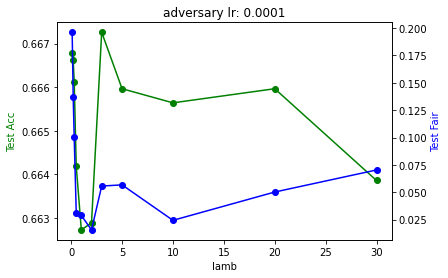

In [19]:

import matplotlib.pyplot as plt

lr_idx = 0

x = eta_arr
y1 = results_acc[lr_idx, :]
y2 = results_fair[lr_idx, :]

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(x, y1, 'go-')
ax2.plot(x, y2, 'bo-')

ax1.set_xlabel('lamb')
ax1.set_ylabel('Test Acc', color='g')
ax2.set_ylabel('Test Fair', color='b')

plt.title(f"adversary lr: {lr_arr[lr_idx]}")

plt.show()


